In [5]:
import warnings
warnings.filterwarnings(action='ignore') 

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 폰트 설정 방법 2
import matplotlib as plt
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
 
font_location = r'Fonts\H2HDRM.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
plt. rc('font', family=font_name)

%matplotlib inline
# 브라우저에서 바로 이미지를 그린다.

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import mean_squared_error


### 추정매출 데이터 불러오기

In [50]:
rev_2020 = pd.read_csv( r'추정매출/서울시 우리마을가게 상권분석서비스(상권-추정매출).csv', encoding = 'cp949' )
rev_2019 = pd.read_csv( r'추정매출/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2019.csv', encoding = 'cp949' )
rev_2018 = pd.read_csv( r'추정매출/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2018.csv', encoding = 'cp949' )
rev_2017 = pd.read_csv( r'추정매출/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2017.csv', encoding = 'cp949' )
rev_2016 = pd.read_csv( r'추정매출/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2016.csv', encoding = 'cp949' )
rev_2015 = pd.read_csv( r'추정매출/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2015.csv', encoding = 'cp949' )

In [51]:
rev_2020

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,6415600,169,...,0,63,106,0,10,139,10,5,5,8
1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,1853749205,8319,...,132,4331,3363,66,2146,2181,1234,1062,1003,8
2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300031,가구,10400909742,5270,...,35,2458,2812,0,0,245,1441,1722,1862,5
3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,807257363,28506,...,580,9007,18931,232,10926,10020,3876,2101,781,6
4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300027,섬유제품,1410497003,41063,...,1445,8135,32928,1478,20434,8248,5427,4241,1235,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66506,2020,1,A,골목상권,1000001,계동길,CS100005,제과점,257814129,27092,...,1205,10426,14742,234,4316,7089,6188,4351,2989,4
66507,2020,1,A,골목상권,1000001,계동길,CS100004,양식음식점,156728306,3589,...,33,1281,2014,5,1361,1116,331,325,157,3
66508,2020,1,A,골목상권,1000001,계동길,CS100003,일식음식점,55484866,1272,...,241,622,508,0,134,245,275,314,162,3
66509,2020,1,A,골목상권,1000001,계동길,CS100002,중식음식점,25767161,1413,...,0,592,694,145,368,240,368,96,69,1


In [52]:
print(rev_2020.shape)
print(rev_2019.shape)
print(rev_2018.shape)
print(rev_2017.shape)
print(rev_2016.shape)
print(rev_2015.shape)

# 66511 + 135578 + 162666 + 166310 + 166874 + 164377
# 최초 데이터 : 862316 행

(66511, 80)
(135578, 80)
(162666, 80)
(166310, 80)
(166874, 80)
(164377, 80)


## 코드에 들어가기 앞서, 내가 관심있는 상권_코드(ba) & 관심있는 서비스업종_코드(sc)가 무엇인지 유념할것.

### 년도, 분기마다 누락된 상권코드가 있는데 이것을 필터링 하겠음.
### 필터링 방법 : 모든 년도,분기의 상권코드를 리스트로 구해서 공통인 값을 남김 : common_ba  

In [53]:
# return_com_ba_by_year : 연도별, 분기별 ba를 추출한다 ( com_ba : common_business_area : 공통 서비스 코드 )
# 2015년 1분기의 상권 코드와, 15년도 2분기 상권 코드 , ... , 20년도 2분기 상권 코드 리스트를 구한다.
# 구해진 상권 코드 들로부터, "공통으로 갖고 있는 값(상권 코드)" 을 리턴한다.
# "공통으로 갖고 있는 값(상권 코드)"  = common_ba

def return_com_ba_by_year(year):
    if (year != 2020):
        common_ba = set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드']).get_group((year,1))['상권_코드'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드']).get_group((year,2))['상권_코드'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드']).get_group((year,3))['상권_코드'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드']).get_group((year,4))['상권_코드'])
    
    if (year == 2020): # 현재 2020년도 2분기 데이터까지밖에 없으므로.
        common_ba = set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드']).get_group((year,1))['상권_코드'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드']).get_group((year,2))['상권_코드'])
    
    return common_ba

In [54]:
# 연도별로(2015~2020) 전체 상권의 공통 상권 코드를 구한다,

common_ba = set(return_com_ba_by_year(2020)) &\
set(return_com_ba_by_year(2019)) &\
set(return_com_ba_by_year(2018)) &\
set(return_com_ba_by_year(2017)) &\
set(return_com_ba_by_year(2016)) &\
set(return_com_ba_by_year(2015))

In [55]:
ba_filt_rev_2020 = rev_2020.loc[rev_2020['상권_코드'].isin(common_ba)]
# 각 연도 매출 데이터에서 공통 상권 코드의 데이터만 갖고오는 필터링을 한다.
# 위 과정을 아래처럼 반복한다.

ba_filt_rev_2019 = rev_2019.loc[rev_2019['상권_코드'].isin(common_ba)]
ba_filt_rev_2018 = rev_2018.loc[rev_2018['상권_코드'].isin(common_ba)]
ba_filt_rev_2017 = rev_2017.loc[rev_2017['상권_코드'].isin(common_ba)]
ba_filt_rev_2016 = rev_2016.loc[rev_2016['상권_코드'].isin(common_ba)]
ba_filt_rev_2015 = rev_2015.loc[rev_2015['상권_코드'].isin(common_ba)]

In [56]:
print(ba_filt_rev_2020.shape)
print(ba_filt_rev_2019.shape)
print(ba_filt_rev_2018.shape)
print(ba_filt_rev_2017.shape)
print(ba_filt_rev_2016.shape)
print(ba_filt_rev_2015.shape)

# 66503 + 135559 + 162552 + 166172 + 166734 + 164241
# 최초 데이터 : 862316 행 -> 공통 서비스 업종 필터링 후 : 861761
# 99.9 % 의 데이터가 남음

(66503, 80)
(135559, 80)
(162552, 80)
(166172, 80)
(166734, 80)
(164241, 80)


### 년도와 상권코드를 입력하면 입력한 상권 및 연도의 4분기 동안 공통된 서비즈 업종을 찾는다

### ( 누락된 서비스 업종은 제외한다 )

In [57]:
len(common_ba)

1483

In [58]:
# return_com_sc_by_year_and_ba : 연도별 & 상권별 서비스 업종 코드를 추출한다 ( com_sc : common_sercice_code : 공통 서비스 코드 )
# 2015년 1분기의 서비스 업종 코드와, 15년도 2분기 서비스 업종코드 , ... , 20년도 2분기 서비스 업종 코드 리스트를 구한다.
# 구해진 서비스 업종 코드 들로부터, "공통으로 갖고 있는 값(서비스업종코드)" 을 리턴한다.
# "공통으로 갖고 있는 값(서비스업종코드)"  = common_sc

def return_com_sc_by_year_and_ba(year,ba):
    if (year != 2020):
        common_sc = set(globals()["ba_filt_rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,1,ba))['서비스_업종_코드_명'])&\
        set(globals()["ba_filt_rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,2,ba))['서비스_업종_코드_명'])&\
        set(globals()["ba_filt_rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,3,ba))['서비스_업종_코드_명'])&\
        set(globals()["ba_filt_rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,4,ba))['서비스_업종_코드_명'])
    
    if (year == 2020): # 현재 2020년도 2분기 데이터까지밖에 없으므로.
        common_sc = set(globals()["ba_filt_rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,1,ba))['서비스_업종_코드_명'])&\
        set(globals()["ba_filt_rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,2,ba))['서비스_업종_코드_명'])
    
    return common_sc

In [59]:
def get_com_sc_ba(interesting_ba):
    common_sc_ba = set(return_com_sc_by_year_and_ba(2020,interesting_ba)) &\
    set(return_com_sc_by_year_and_ba(2019,interesting_ba)) &\
    set(return_com_sc_by_year_and_ba(2018,interesting_ba)) &\
    set(return_com_sc_by_year_and_ba(2017,interesting_ba)) &\
    set(return_com_sc_by_year_and_ba(2016,interesting_ba)) &\
    set(return_com_sc_by_year_and_ba(2015,interesting_ba))
    
    return common_sc_ba
    

In [49]:
# 1483개의 상권아래 총 27049개의 서비스 업종이 있음.
# 15년도 1분기 ~ 20년도 2분기 : 22개
# 22 * 27049 -> 595078
# 862316 -> 595078 = 전체 데이터에서 69% 이용 가능.
# 쉽게 생각하면 1496개 상권 및 업종 데이터 중, 1050개 정도 분석 가능함.

sc_num = 0
for ba in common_ba:
    globals()["common_sc_{}".format(ba)] = get_com_sc_ba(ba)
    print(str(ba)+" : 상권 아래 서비스업종 개수 : "+str(len(globals()["common_sc_{}".format(ba)])))
    sc_num = sc_num + len(globals()["common_sc_{}".format(ba)])
    
print(sc_num)

1000001 : 상권 아래 서비스업종 개수 : 14
1000002 : 상권 아래 서비스업종 개수 : 10
1000003 : 상권 아래 서비스업종 개수 : 21
1000004 : 상권 아래 서비스업종 개수 : 13
1000005 : 상권 아래 서비스업종 개수 : 8
1000006 : 상권 아래 서비스업종 개수 : 7
1000007 : 상권 아래 서비스업종 개수 : 11
1000008 : 상권 아래 서비스업종 개수 : 7
1000009 : 상권 아래 서비스업종 개수 : 11
1000010 : 상권 아래 서비스업종 개수 : 17
1000011 : 상권 아래 서비스업종 개수 : 20
1000012 : 상권 아래 서비스업종 개수 : 12
1000013 : 상권 아래 서비스업종 개수 : 7
1000014 : 상권 아래 서비스업종 개수 : 4
1000015 : 상권 아래 서비스업종 개수 : 21
1000016 : 상권 아래 서비스업종 개수 : 21
1000017 : 상권 아래 서비스업종 개수 : 16
1000018 : 상권 아래 서비스업종 개수 : 12
1000019 : 상권 아래 서비스업종 개수 : 17
1000020 : 상권 아래 서비스업종 개수 : 15
1000021 : 상권 아래 서비스업종 개수 : 15
1000022 : 상권 아래 서비스업종 개수 : 16
1000023 : 상권 아래 서비스업종 개수 : 9
1000024 : 상권 아래 서비스업종 개수 : 5
1000025 : 상권 아래 서비스업종 개수 : 2
1000026 : 상권 아래 서비스업종 개수 : 7
1000027 : 상권 아래 서비스업종 개수 : 11
1000028 : 상권 아래 서비스업종 개수 : 19
1000029 : 상권 아래 서비스업종 개수 : 3
1000030 : 상권 아래 서비스업종 개수 : 13
1000031 : 상권 아래 서비스업종 개수 : 10
1000032 : 상권 아래 서비스업종 개수 : 25
1000033 : 상권 아래 서비스업종 개수 : 18
1000034 : 상권 아래 서비스업

1000277 : 상권 아래 서비스업종 개수 : 13
1000278 : 상권 아래 서비스업종 개수 : 28
1000279 : 상권 아래 서비스업종 개수 : 5
1000280 : 상권 아래 서비스업종 개수 : 3
1000281 : 상권 아래 서비스업종 개수 : 20
1000282 : 상권 아래 서비스업종 개수 : 15
1000283 : 상권 아래 서비스업종 개수 : 5
1000284 : 상권 아래 서비스업종 개수 : 22
1000285 : 상권 아래 서비스업종 개수 : 9
1000286 : 상권 아래 서비스업종 개수 : 18
1000287 : 상권 아래 서비스업종 개수 : 17
1000288 : 상권 아래 서비스업종 개수 : 31
1000289 : 상권 아래 서비스업종 개수 : 11
1000290 : 상권 아래 서비스업종 개수 : 12
1000291 : 상권 아래 서비스업종 개수 : 13
1000292 : 상권 아래 서비스업종 개수 : 22
1000293 : 상권 아래 서비스업종 개수 : 14
1000294 : 상권 아래 서비스업종 개수 : 16
1000295 : 상권 아래 서비스업종 개수 : 24
1000296 : 상권 아래 서비스업종 개수 : 3
1000297 : 상권 아래 서비스업종 개수 : 16
1000298 : 상권 아래 서비스업종 개수 : 15
1000299 : 상권 아래 서비스업종 개수 : 16
1000300 : 상권 아래 서비스업종 개수 : 14
1000301 : 상권 아래 서비스업종 개수 : 25
1000302 : 상권 아래 서비스업종 개수 : 23
1000303 : 상권 아래 서비스업종 개수 : 15
1000304 : 상권 아래 서비스업종 개수 : 12
1000305 : 상권 아래 서비스업종 개수 : 15
1000306 : 상권 아래 서비스업종 개수 : 10
1000307 : 상권 아래 서비스업종 개수 : 2
1000308 : 상권 아래 서비스업종 개수 : 17
1000309 : 상권 아래 서비스업종 개수 : 18
1000310 : 상권 아래 

1000552 : 상권 아래 서비스업종 개수 : 21
1000553 : 상권 아래 서비스업종 개수 : 14
1000554 : 상권 아래 서비스업종 개수 : 22
1000555 : 상권 아래 서비스업종 개수 : 11
1000556 : 상권 아래 서비스업종 개수 : 23
1000557 : 상권 아래 서비스업종 개수 : 20
1000558 : 상권 아래 서비스업종 개수 : 15
1000559 : 상권 아래 서비스업종 개수 : 26
1000560 : 상권 아래 서비스업종 개수 : 17
1000561 : 상권 아래 서비스업종 개수 : 25
1000562 : 상권 아래 서비스업종 개수 : 13
1000563 : 상권 아래 서비스업종 개수 : 25
1000564 : 상권 아래 서비스업종 개수 : 14
1000565 : 상권 아래 서비스업종 개수 : 9
1000566 : 상권 아래 서비스업종 개수 : 26
1000567 : 상권 아래 서비스업종 개수 : 23
1000568 : 상권 아래 서비스업종 개수 : 14
1000569 : 상권 아래 서비스업종 개수 : 23
1000570 : 상권 아래 서비스업종 개수 : 12
1000571 : 상권 아래 서비스업종 개수 : 8
1000572 : 상권 아래 서비스업종 개수 : 10
1000573 : 상권 아래 서비스업종 개수 : 18
1000574 : 상권 아래 서비스업종 개수 : 12
1000575 : 상권 아래 서비스업종 개수 : 20
1000576 : 상권 아래 서비스업종 개수 : 17
1000577 : 상권 아래 서비스업종 개수 : 21
1000578 : 상권 아래 서비스업종 개수 : 22
1000579 : 상권 아래 서비스업종 개수 : 16
1000580 : 상권 아래 서비스업종 개수 : 25
1000581 : 상권 아래 서비스업종 개수 : 3
1000582 : 상권 아래 서비스업종 개수 : 24
1000583 : 상권 아래 서비스업종 개수 : 20
1000584 : 상권 아래 서비스업종 개수 : 10
1000585 : 상권 

1000828 : 상권 아래 서비스업종 개수 : 13
1000829 : 상권 아래 서비스업종 개수 : 20
1000830 : 상권 아래 서비스업종 개수 : 25
1000831 : 상권 아래 서비스업종 개수 : 24
1000832 : 상권 아래 서비스업종 개수 : 10
1000833 : 상권 아래 서비스업종 개수 : 18
1000834 : 상권 아래 서비스업종 개수 : 31
1000835 : 상권 아래 서비스업종 개수 : 14
1000836 : 상권 아래 서비스업종 개수 : 11
1000837 : 상권 아래 서비스업종 개수 : 21
1000838 : 상권 아래 서비스업종 개수 : 11
1000839 : 상권 아래 서비스업종 개수 : 31
1000840 : 상권 아래 서비스업종 개수 : 13
1000841 : 상권 아래 서비스업종 개수 : 2
1000842 : 상권 아래 서비스업종 개수 : 15
1000843 : 상권 아래 서비스업종 개수 : 8
1000844 : 상권 아래 서비스업종 개수 : 10
1000845 : 상권 아래 서비스업종 개수 : 22
1000846 : 상권 아래 서비스업종 개수 : 25
1000847 : 상권 아래 서비스업종 개수 : 27
1000848 : 상권 아래 서비스업종 개수 : 17
1000849 : 상권 아래 서비스업종 개수 : 17
1000850 : 상권 아래 서비스업종 개수 : 18
1000851 : 상권 아래 서비스업종 개수 : 11
1000852 : 상권 아래 서비스업종 개수 : 21
1000853 : 상권 아래 서비스업종 개수 : 17
1000854 : 상권 아래 서비스업종 개수 : 23
1000855 : 상권 아래 서비스업종 개수 : 18
1000856 : 상권 아래 서비스업종 개수 : 25
1000857 : 상권 아래 서비스업종 개수 : 13
1000858 : 상권 아래 서비스업종 개수 : 17
1000859 : 상권 아래 서비스업종 개수 : 19
1000860 : 상권 아래 서비스업종 개수 : 17
1000861 : 상권

1001102 : 상권 아래 서비스업종 개수 : 15
1001103 : 상권 아래 서비스업종 개수 : 32
1001104 : 상권 아래 서비스업종 개수 : 17
1001105 : 상권 아래 서비스업종 개수 : 32
1001106 : 상권 아래 서비스업종 개수 : 12
1001107 : 상권 아래 서비스업종 개수 : 30
1001108 : 상권 아래 서비스업종 개수 : 17
1001109 : 상권 아래 서비스업종 개수 : 28
1001110 : 상권 아래 서비스업종 개수 : 24
1001111 : 상권 아래 서비스업종 개수 : 31
1001112 : 상권 아래 서비스업종 개수 : 20
1001113 : 상권 아래 서비스업종 개수 : 18
1001114 : 상권 아래 서비스업종 개수 : 20
1001115 : 상권 아래 서비스업종 개수 : 29
1001116 : 상권 아래 서비스업종 개수 : 5
1001117 : 상권 아래 서비스업종 개수 : 30
1001118 : 상권 아래 서비스업종 개수 : 18
1001119 : 상권 아래 서비스업종 개수 : 24
1001120 : 상권 아래 서비스업종 개수 : 25
1001121 : 상권 아래 서비스업종 개수 : 15
1001122 : 상권 아래 서비스업종 개수 : 15
1001123 : 상권 아래 서비스업종 개수 : 29
1001124 : 상권 아래 서비스업종 개수 : 22
1001125 : 상권 아래 서비스업종 개수 : 14
1001126 : 상권 아래 서비스업종 개수 : 10
1001127 : 상권 아래 서비스업종 개수 : 41
1001128 : 상권 아래 서비스업종 개수 : 9
1001129 : 상권 아래 서비스업종 개수 : 28
1001130 : 상권 아래 서비스업종 개수 : 16
1001131 : 상권 아래 서비스업종 개수 : 28
1001132 : 상권 아래 서비스업종 개수 : 21
1001133 : 상권 아래 서비스업종 개수 : 25
1001134 : 상권 아래 서비스업종 개수 : 32
1001135 : 상권

1001383 : 상권 아래 서비스업종 개수 : 16
1001384 : 상권 아래 서비스업종 개수 : 6
1001385 : 상권 아래 서비스업종 개수 : 22
1001386 : 상권 아래 서비스업종 개수 : 6
1001387 : 상권 아래 서비스업종 개수 : 5
1001388 : 상권 아래 서비스업종 개수 : 3
1001390 : 상권 아래 서비스업종 개수 : 20
1001391 : 상권 아래 서비스업종 개수 : 26
1001392 : 상권 아래 서비스업종 개수 : 8
1001393 : 상권 아래 서비스업종 개수 : 10
1001394 : 상권 아래 서비스업종 개수 : 28
1001395 : 상권 아래 서비스업종 개수 : 34
1001396 : 상권 아래 서비스업종 개수 : 16
1001397 : 상권 아래 서비스업종 개수 : 29
1001398 : 상권 아래 서비스업종 개수 : 11
1001399 : 상권 아래 서비스업종 개수 : 17
1001400 : 상권 아래 서비스업종 개수 : 10
1001402 : 상권 아래 서비스업종 개수 : 21
1001403 : 상권 아래 서비스업종 개수 : 15
1001404 : 상권 아래 서비스업종 개수 : 20
1001405 : 상권 아래 서비스업종 개수 : 6
1001406 : 상권 아래 서비스업종 개수 : 21
1001407 : 상권 아래 서비스업종 개수 : 1
1001408 : 상권 아래 서비스업종 개수 : 6
1001409 : 상권 아래 서비스업종 개수 : 28
1001410 : 상권 아래 서비스업종 개수 : 7
1001411 : 상권 아래 서비스업종 개수 : 35
1001412 : 상권 아래 서비스업종 개수 : 29
1001413 : 상권 아래 서비스업종 개수 : 33
1001414 : 상권 아래 서비스업종 개수 : 29
1001415 : 상권 아래 서비스업종 개수 : 21
1001416 : 상권 아래 서비스업종 개수 : 4
1001417 : 상권 아래 서비스업종 개수 : 11
1001418 : 상권 아래 서비스업

### 그리고나서 모든 연도와 비교하여 누락된 서비스 업종을 제외한다

In [60]:
# 연도별로(2015~2020) 관심있는 상권의 공통 서비스 업종 코드를 구한다,
# 그리고 연도별로 구한 공통 서비스 업종 코드에서, 
# 전체 기간끼리 비교하여 모든 기간동안 공통으로 갖고있는 서비스 업종 코드 리스트를 구한다.
# 이 경우, 내가 관심있는 상권은 1001496 이었으므로, 변수명을 "common_sc_1001496" 로 규정한다.

interesting_ba = 1001496
# 관심있는 상권

# 2020~2015 : 년도
common_sc_1001496 = set(return_com_sc_by_year_and_ba(2020,interesting_ba)) &\
set(return_com_sc_by_year_and_ba(2019,interesting_ba)) &\
set(return_com_sc_by_year_and_ba(2018,interesting_ba)) &\
set(return_com_sc_by_year_and_ba(2017,interesting_ba)) &\
set(return_com_sc_by_year_and_ba(2016,interesting_ba)) &\
set(return_com_sc_by_year_and_ba(2015,interesting_ba))

### 최종적으로 분석에 이용할 서비스 업종의 개수를 확인한다

In [61]:
# 내가 관심있는 상권, 1001496 의 전체기간 공통 서비스 업종 코드 개수는 32개다.

len(common_sc_1001496)

32

### 위에서 구한 common_sc(공통 서비스 업종)으로 데이터를 필터링한다

In [63]:
# 앞서 구한 공통 서비스 업종 코드로, 데이터 필터링을 한다.


sc_filt_rev_2020 = ba_filt_rev_2020.loc[ba_filt_rev_2020['서비스_업종_코드_명'].isin(common_sc_1001496)]
# 강남 매출 데이터에서 1001496 상권의 32개 서비스 업종 코드의 데이터만 갖고오는 필터링을 한다.
# 위 과정을 아래처럼 반복한다.

sc_filt_rev_2019 = ba_filt_rev_2019.loc[ba_filt_rev_2019['서비스_업종_코드_명'].isin(common_sc_1001496)]
sc_filt_rev_2018 = ba_filt_rev_2018.loc[ba_filt_rev_2018['서비스_업종_코드_명'].isin(common_sc_1001496)]
sc_filt_rev_2017 = ba_filt_rev_2017.loc[ba_filt_rev_2017['서비스_업종_코드_명'].isin(common_sc_1001496)]
sc_filt_rev_2016 = ba_filt_rev_2016.loc[ba_filt_rev_2016['서비스_업종_코드_명'].isin(common_sc_1001496)]
sc_filt_rev_2015 = ba_filt_rev_2015.loc[ba_filt_rev_2015['서비스_업종_코드_명'].isin(common_sc_1001496)]

In [64]:
print(sc_filt_rev_2020.shape)
print(sc_filt_rev_2019.shape)
print(sc_filt_rev_2018.shape)
print(sc_filt_rev_2017.shape)
print(sc_filt_rev_2016.shape)
print(sc_filt_rev_2015.shape)

# 40475 + 82258 + 94005 + 96131 + 96867 + 95953
# 최초 데이터 : 862316 행 -> 공통 서비스 업종 필터링 후 : 505689
# 58.6 % 의 데이터가 남음

(40469, 80)
(82240, 80)
(93913, 80)
(96028, 80)
(96764, 80)
(95849, 80)


In [95]:
# 성공적으로 수행된 것을 볼 수 있다.
sc_filt_rev_2015

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2015,1,D,발달상권,1001018,포이사거리_2,CS300021,문구,3390014653,88106,...,41,26390,18879,385,8047,13300,11808,8195,3532,19
1,2015,1,A,골목상권,1000481,성미산로11길,CS300011,일반의류,477810637,1339,...,9,781,406,0,64,472,216,328,108,7
3,2015,1,R,전통시장,1001458,인헌시장,CS100005,제과점,312469941,38207,...,3475,13485,22883,352,6467,13345,9907,4002,2294,3
6,2015,1,D,발달상권,1001098,포스코사거리_1,CS300022,화장품,6404925796,72308,...,3483,11365,55416,1401,22775,18721,12141,8049,3700,34
10,2015,1,A,골목상권,1000414,은평로20길,CS200028,미용실,26040385,2022,...,86,1617,348,40,209,386,718,478,136,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164368,2015,4,D,발달상권,1001138,압구정 로데오거리_1,CS200030,피부관리실,1789382655,7508,...,218,1771,5353,24,1031,1988,1677,1659,749,30
164370,2015,4,A,골목상권,1000773,여의대방로24길,CS200028,미용실,10091659,358,...,14,169,189,0,47,115,146,19,31,2
164371,2015,4,A,골목상권,1000607,화곡로59길,CS300001,슈퍼마켓,1786328785,166372,...,28809,65824,90516,2267,27077,37164,34314,36148,19372,4
164374,2015,4,A,골목상권,1000207,제기로5길,CS300002,편의점,479803060,98435,...,22128,62563,35668,5196,58253,17633,8113,7774,1263,3


### 내가 관심있는 상권을 검색

In [94]:
# interesting_ba = 1001496

gangnam_rev_2020 = sc_filt_rev_2020.groupby(['상권_코드']).get_group((interesting_ba))
gangnam_rev_2019 = sc_filt_rev_2019.groupby(['상권_코드']).get_group((interesting_ba))
gangnam_rev_2018 = sc_filt_rev_2018.groupby(['상권_코드']).get_group((interesting_ba))
gangnam_rev_2017 = sc_filt_rev_2017.groupby(['상권_코드']).get_group((interesting_ba))
gangnam_rev_2016 = sc_filt_rev_2016.groupby(['상권_코드']).get_group((interesting_ba))
gangnam_rev_2015 = sc_filt_rev_2015.groupby(['상권_코드']).get_group((interesting_ba))

gangnam_rev_2015

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
1555,2015,1,U,관광특구,1001496,강남 마이스 관광특구,CS200007,치과의원,515286370,2506,...,22,1157,1218,3,482,725,452,423,291,5
2773,2015,1,U,관광특구,1001496,강남 마이스 관광특구,CS300004,핸드폰,157997485,3604,...,81,1458,1767,78,938,1118,614,321,158,5
2778,2015,1,U,관광특구,1001496,강남 마이스 관광특구,CS100004,양식음식점,8456236514,240779,...,17788,79703,118986,1767,72915,75432,27377,14810,6386,37
6681,2015,1,U,관광특구,1001496,강남 마이스 관광특구,CS200006,일반의원,666156294,10925,...,0,4528,6155,56,3209,3515,1843,1411,651,4
6688,2015,1,U,관광특구,1001496,강남 마이스 관광특구,CS300026,완구,2593575491,55487,...,1575,34540,20806,1340,17253,21863,11956,1968,965,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157918,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS300016,안경,953225275,7646,...,273,2283,5146,109,2590,2477,1082,739,431,7
159522,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS200030,피부관리실,188056807,1524,...,155,574,765,3,258,572,223,176,108,3
159608,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS100001,한식음식점,10517058701,409082,...,10405,146867,194812,6072,113240,113840,63022,31369,14135,42
161095,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS200007,치과의원,571691177,2416,...,27,1282,1134,3,486,668,474,474,311,5


### 필터링한 데이터를 합쳐서 하나의 큰 데이터로 만든다

In [93]:
gangnam_all_rev = gangnam_rev_2020.append(gangnam_rev_2019, ignore_index=False)\
.append(gangnam_rev_2018, ignore_index=False)\
.append(gangnam_rev_2017, ignore_index=False)\
.append(gangnam_rev_2016, ignore_index=False)\
.append(gangnam_rev_2015, ignore_index=False)

gangnam_all_rev

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,1853749205,8319,...,132,4331,3363,66,2146,2181,1234,1062,1003,8
1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,807257363,28506,...,580,9007,18931,232,10926,10020,3876,2101,781,6
2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300027,섬유제품,1410497003,41063,...,1445,8135,32928,1478,20434,8248,5427,4241,1235,6
3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300026,완구,506304623,7512,...,0,4912,2600,249,2291,2347,2089,387,149,8
4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300024,운동/경기용품,10213546282,35419,...,1376,18762,16339,555,10560,12107,5540,3479,2861,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157918,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS300016,안경,953225275,7646,...,273,2283,5146,109,2590,2477,1082,739,431,7
159522,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS200030,피부관리실,188056807,1524,...,155,574,765,3,258,572,223,176,108,3
159608,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS100001,한식음식점,10517058701,409082,...,10405,146867,194812,6072,113240,113840,63022,31369,14135,42
161095,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS200007,치과의원,571691177,2416,...,27,1282,1134,3,486,668,474,474,311,5


### 쓸모없는 열은 제외한다.

In [69]:
gangnam_all_rev = gangnam_all_rev.drop(['상권_구분_코드_명','상권_코드_명','서비스_업종_코드'], axis=1)

In [36]:
# gangnam_all_rev.to_csv(r'gangnam_all_rev.csv', encoding = 'cp949')
# 다운로드해서 제대로 됐는지 확인하기 위함이었음

### 위 과정에서 인풋 데이터 준비는 1차적으로 끝났고, 이제 아웃풋 데이터를 준비한다

In [70]:
fr_2020 = pd.read_csv( r'폐업률/서울시 우리마을가게 상권분석서비스(상권-점포)_2020_new.csv', encoding = 'cp949' )
fr_2019 = pd.read_csv( r'폐업률/서울시 우리마을가게 상권분석서비스(상권-점포)_2019_new.csv', encoding = 'cp949' )
fr_2018 = pd.read_csv( r'폐업률/서울시 우리마을가게 상권분석서비스(상권-점포)_2018_new.csv', encoding = 'cp949' )
fr_2017 = pd.read_csv( r'폐업률/서울시 우리마을가게 상권분석서비스(상권-점포)_2017_new.csv', encoding = 'cp949' )
fr_2016 = pd.read_csv( r'폐업률/서울시 우리마을가게 상권분석서비스(상권-점포)_2016_new.csv', encoding = 'cp949' )
fr_2015 = pd.read_csv( r'폐업률/서울시 우리마을가게 상권분석서비스(상권-점포)_2015_new.csv', encoding = 'cp949' )

In [40]:
fr_2020

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,폐업_률
0,0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,0
1,1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300042,주유소,0
2,2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300041,예술품,0
3,3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300040,재생용품 판매점,0
4,4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300038,자동차부품,0
...,...,...,...,...,...,...,...,...,...,...
184550,184550,2020,1,A,골목상권,1000001,계동길,CS100005,제과점,0
184551,184551,2020,1,A,골목상권,1000001,계동길,CS100004,양식음식점,0
184552,184552,2020,1,A,골목상권,1000001,계동길,CS100003,일식음식점,0
184553,184553,2020,1,A,골목상권,1000001,계동길,CS100002,중식음식점,0


In [99]:
gangnam_fr_2020 = fr_2020.groupby(['상권_코드']).get_group((interesting_ba))[['기준_년_코드','기준_분기_코드','폐업_률','서비스_업종_코드_명']]
gangnam_fr_2019 = fr_2019.groupby(['상권_코드']).get_group((interesting_ba))[['기준_년_코드','기준_분기_코드','폐업_률','서비스_업종_코드_명']]
gangnam_fr_2018 = fr_2018.groupby(['상권_코드']).get_group((interesting_ba))[['기준_년_코드','기준_분기_코드','폐업_률','서비스_업종_코드_명']]
gangnam_fr_2017 = fr_2017.groupby(['상권_코드']).get_group((interesting_ba))[['기준_년_코드','기준_분기_코드','폐업_률','서비스_업종_코드_명']]
gangnam_fr_2016 = fr_2016.groupby(['상권_코드']).get_group((interesting_ba))[['기준_년_코드','기준_분기_코드','폐업_률','서비스_업종_코드_명']]
gangnam_fr_2015 = fr_2015.groupby(['상권_코드']).get_group((interesting_ba))[['기준_년_코드','기준_분기_코드','폐업_률','서비스_업종_코드_명']]

gangnam_fr_2020


,기준_년_코드,기준_분기_코드,폐업_률,서비스_업종_코드_명
0,2020,2,0,전자상거래업
1,2020,2,0,주유소
2,2020,2,0,예술품
3,2020,2,0,재생용품 판매점
4,2020,2,0,자동차부품
...,...,...,...,...
92525,2020,1,6,제과점
92526,2020,1,10,양식음식점
92527,2020,1,5,일식음식점
92528,2020,1,0,중식음식점


### 각 연도의 공통된 서비스 업종을 찾는다

In [100]:
def fr_return_com_sc_by_year_and_ba(year,ba):
    if (year != 2020):
        # getgroupt 의 1,2,3,4 는 분기임. 1 : 1분기
        common_sc = set(globals()["fr_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,1,ba))['서비스_업종_코드_명'])&\
        set(globals()["fr_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,2,ba))['서비스_업종_코드_명'])&\
        set(globals()["fr_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,3,ba))['서비스_업종_코드_명'])&\
        set(globals()["fr_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,4,ba))['서비스_업종_코드_명'])
    
    #2020년은 2분기밖에 데이터가 없으므로
    if (year == 2020):
        common_sc = set(globals()["fr_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,1,ba))['서비스_업종_코드_명'])&\
        set(globals()["fr_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,2,ba))['서비스_업종_코드_명'])
    
    return common_sc

### 모든 연도에 공통된 서비스 업종을 찾고, 누락된 서비스 업종은 제외한다

In [101]:
fr_common_sc_1001496 = set(fr_return_com_sc_by_year_and_ba(2020,interesting_ba)) &\
set(fr_return_com_sc_by_year_and_ba(2019,interesting_ba)) &\
set(fr_return_com_sc_by_year_and_ba(2018,interesting_ba)) &\
set(fr_return_com_sc_by_year_and_ba(2017,interesting_ba)) &\
set(fr_return_com_sc_by_year_and_ba(2016,interesting_ba)) &\
set(fr_return_com_sc_by_year_and_ba(2015,interesting_ba))

In [102]:
print(len(common_sc_1001496))
print(len(fr_common_sc_1001496))

32
77


### 중요 : 인풋 데이터의 서비스업종과 아웃풋 데이터의 서비스 업종이 일치하는지 확인해야 한다

In [103]:
_common_sc = set(common_sc_1001496) & set(fr_common_sc_1001496)
len(_common_sc) # common_sc_1001496 이것이 공통 sc

32

In [104]:
gangnam_new_fr_2020 = gangnam_fr_2020.loc[gangnam_fr_2020['서비스_업종_코드_명'].isin(_common_sc)]
gangnam_new_fr_2019 = gangnam_fr_2019.loc[gangnam_fr_2019['서비스_업종_코드_명'].isin(_common_sc)]
gangnam_new_fr_2018 = gangnam_fr_2018.loc[gangnam_fr_2018['서비스_업종_코드_명'].isin(_common_sc)]
gangnam_new_fr_2017 = gangnam_fr_2017.loc[gangnam_fr_2017['서비스_업종_코드_명'].isin(_common_sc)]
gangnam_new_fr_2016 = gangnam_fr_2016.loc[gangnam_fr_2016['서비스_업종_코드_명'].isin(_common_sc)]
gangnam_new_fr_2015 = gangnam_fr_2015.loc[gangnam_fr_2015['서비스_업종_코드_명'].isin(_common_sc)]

In [105]:
gangnam_new_fr_2015

,기준_년_코드,기준_분기_코드,폐업_률,서비스_업종_코드_명
224,2015,1,0,피부관리실
1415,2015,1,17,섬유제품
5642,2015,1,0,네일숍
10742,2015,1,7,신발
12418,2015,1,0,문구
...,...,...,...,...
325909,2015,4,0,일식음식점
326527,2015,4,0,가전제품
327785,2015,4,0,반찬가게
328558,2015,4,0,미용실


In [79]:
# 아래 코드는 생존율 예측시 필요

# gangnam_new_fr_2020['폐업_률'] = 100 - gangnam_new_fr_2020['폐업_률']
# gangnam_new_fr_2019['폐업_률'] = 100 - gangnam_new_fr_2019['폐업_률']
# gangnam_new_fr_2018['폐업_률'] = 100 - gangnam_new_fr_2018['폐업_률']
# gangnam_new_fr_2017['폐업_률'] = 100 - gangnam_new_fr_2017['폐업_률']
# gangnam_new_fr_2016['폐업_률'] = 100 - gangnam_new_fr_2016['폐업_률']
# gangnam_new_fr_2015['폐업_률'] = 100 - gangnam_new_fr_2015['폐업_률']

# gangnam_new_fr_2020                                                     

,폐업_률,서비스_업종_코드_명
10,0,가전제품
13,0,화초
14,0,섬유제품
15,14,완구
16,23,운동/경기용품
...,...,...
92525,6,제과점
92526,10,양식음식점
92527,5,일식음식점
92528,0,중식음식점


### 인풋 데이터의 서비스업종과 아웃풋 데이터의 서비스 업종이 일치한다면 이제 합쳐도 된다.

### 이때, df의 인덱스가 서로 달라서 합치는데 문제가 되니, 인덱스를 초기화 한다

In [106]:
gangnam_rev_2015 = gangnam_rev_2015.reset_index(drop=True, inplace=False)
gangnam_new_fr_2015 = gangnam_new_fr_2015.reset_index(drop=True, inplace=False)

gangnam_2015 = pd.merge(gangnam_rev_2015, gangnam_new_fr_2015, how='left',on=['기준_년_코드','기준_분기_코드','서비스_업종_코드_명']) 
gangnam_2015

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수,폐업_률
0,2015,1,U,관광특구,1001496,강남 마이스 관광특구,CS200007,치과의원,515286370,2506,...,1157,1218,3,482,725,452,423,291,5,0
1,2015,1,U,관광특구,1001496,강남 마이스 관광특구,CS300004,핸드폰,157997485,3604,...,1458,1767,78,938,1118,614,321,158,5,0
2,2015,1,U,관광특구,1001496,강남 마이스 관광특구,CS100004,양식음식점,8456236514,240779,...,79703,118986,1767,72915,75432,27377,14810,6386,37,8
3,2015,1,U,관광특구,1001496,강남 마이스 관광특구,CS200006,일반의원,666156294,10925,...,4528,6155,56,3209,3515,1843,1411,651,4,0
4,2015,1,U,관광특구,1001496,강남 마이스 관광특구,CS300026,완구,2593575491,55487,...,34540,20806,1340,17253,21863,11956,1968,965,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS300016,안경,953225275,7646,...,2283,5146,109,2590,2477,1082,739,431,7,0
124,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS200030,피부관리실,188056807,1524,...,574,765,3,258,572,223,176,108,3,0
125,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS100001,한식음식점,10517058701,409082,...,146867,194812,6072,113240,113840,63022,31369,14135,42,0
126,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS200007,치과의원,571691177,2416,...,1282,1134,3,486,668,474,474,311,5,0


### 모든 연도에 대해 인풋 데이터와 아웃풋 데이터를 합쳐준다

In [115]:
start_year = 2015
end_year = 2020

for i in range(start_year,end_year+1):
    globals()["gangnam__rev_{}".format(i)] = globals()["gangnam_rev_{}".format(i)].reset_index(drop=True, inplace=False)
    globals()["gangnam_new_fr_{}".format(i)] = globals()["gangnam_new_fr_{}".format(i)].reset_index(drop=True, inplace=False)
    globals()["gangnam_{}".format(i)] = pd.merge(
        globals()["gangnam_rev_{}".format(i)],  globals()["gangnam_new_fr_{}".format(i)], how='left',on=['기준_년_코드','기준_분기_코드','서비스_업종_코드_명']) 
    


In [116]:
print(gangnam_2019.shape)
print(gangnam_2018.shape)
print(gangnam_2017.shape)
print(gangnam_2016.shape)
print(gangnam_2015.shape)

(128, 81)
(128, 81)
(128, 81)
(128, 81)
(128, 81)


### 만들어진 년도별 인풋+아웃풋 데이터를 하나의 큰 데이터로 만들어준다

In [117]:
gangnam = pd.concat( [gangnam_2020, gangnam_2019, gangnam_2018, gangnam_2017, gangnam_2016, gangnam_2015 ], axis=0) 
gangnam

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수,폐업_률
0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,1853749205,8319,...,4331,3363,66,2146,2181,1234,1062,1003,8,0
1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,807257363,28506,...,9007,18931,232,10926,10020,3876,2101,781,6,0
2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300027,섬유제품,1410497003,41063,...,8135,32928,1478,20434,8248,5427,4241,1235,6,0
3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300026,완구,506304623,7512,...,4912,2600,249,2291,2347,2089,387,149,8,14
4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300024,운동/경기용품,10213546282,35419,...,18762,16339,555,10560,12107,5540,3479,2861,14,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS300016,안경,953225275,7646,...,2283,5146,109,2590,2477,1082,739,431,7,0
124,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS200030,피부관리실,188056807,1524,...,574,765,3,258,572,223,176,108,3,0
125,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS100001,한식음식점,10517058701,409082,...,146867,194812,6072,113240,113840,63022,31369,14135,42,0
126,2015,4,U,관광특구,1001496,강남 마이스 관광특구,CS200007,치과의원,571691177,2416,...,1282,1134,3,486,668,474,474,311,5,0


In [118]:
gangnam = gangnam.drop(['상권_구분_코드','상권_코드','상권_구분_코드_명','상권_코드_명','서비스_업종_코드_명'],axis=1)

In [119]:
gangnam

,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수,폐업_률
0,2020,2,CS300032,1853749205,8319,58,42,12,9,7,...,4331,3363,66,2146,2181,1234,1062,1003,8,0
1,2020,2,CS300028,807257363,28506,77,23,12,14,14,...,9007,18931,232,10926,10020,3876,2101,781,6,0
2,2020,2,CS300027,1410497003,41063,64,36,11,13,14,...,8135,32928,1478,20434,8248,5427,4241,1235,6,0
3,2020,2,CS300026,506304623,7512,59,41,10,8,8,...,4912,2600,249,2291,2347,2089,387,149,8,14
4,2020,2,CS300024,10213546282,35419,77,23,13,18,16,...,18762,16339,555,10560,12107,5540,3479,2861,14,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2015,4,CS300016,953225275,7646,69,31,13,13,13,...,2283,5146,109,2590,2477,1082,739,431,7,0
124,2015,4,CS200030,188056807,1524,70,30,13,12,15,...,574,765,3,258,572,223,176,108,3,0
125,2015,4,CS100001,10517058701,409082,73,27,13,13,14,...,146867,194812,6072,113240,113840,63022,31369,14135,42,0
126,2015,4,CS200007,571691177,2416,92,8,28,19,19,...,1282,1134,3,486,668,474,474,311,5,0


In [144]:
# 관심있는 서비스 업종만 사용
# 시계 및 귀금속 : CS300017
# 커피 : CS100010
# 치킨 : CS100007
# 주유소 : CS300042

coffee = 'CS300010'

gangnam_coffee = gangnam.groupby(['서비스_업종_코드']).get_group((coffee))
gangnam_coffee


,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수,폐업_률
13,2020,2,CS300010,9612313193,241778,84,16,14,12,26,...,104583,131462,10,56625,111183,38390,17241,12597,12,0
45,2020,1,CS300010,7421071405,93925,63,37,11,11,10,...,56735,33590,0,16152,45574,13434,8197,6967,12,0
4,2019,1,CS300010,5214000000,189240,81,19,14,14,16,...,101965,69157,858,48577,53503,33536,20049,14600,13,0
50,2019,2,CS300010,5214000000,173937,80,20,14,14,16,...,95177,61992,583,43830,46124,30862,19910,15861,13,0
83,2019,3,CS300010,5214000000,173785,81,19,16,15,16,...,94445,64147,831,46170,46831,32199,17819,14742,13,0
107,2019,4,CS300010,11517000000,141145,70,30,9,9,8,...,74206,63212,26,22559,88876,16338,4560,5058,13,0
18,2018,1,CS300010,1716436352,49420,82,18,13,18,14,...,30348,15811,0,13752,14897,10777,5270,1469,11,0
53,2018,2,CS300010,2112997805,123197,86,14,14,12,18,...,76830,35429,189,31951,32396,25852,15710,6165,12,0
76,2018,3,CS300010,3205354552,178850,84,16,15,15,16,...,101895,57885,763,46547,45933,32922,21933,11682,13,0
97,2018,4,CS300010,3570719498,216553,80,21,16,14,15,...,115758,78983,1275,56250,63834,39202,22561,11620,13,0


In [122]:
gangnam_coffee_col = gangnam_coffee.columns
print(gangnam_coffee_col)
print(len(gangnam_coffee_col))

Index(['기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '당월_매출_금액', '당월_매출_건수', '주중_매출_비율',
       '주말_매출_비율', '월요일_매출_비율', '화요일_매출_비율', '수요일_매출_비율', '목요일_매출_비율',
       '금요일_매출_비율', '토요일_매출_비율', '일요일_매출_비율', '시간대_00~06_매출_비율',
       '시간대_06~11_매출_비율', '시간대_11~14_매출_비율', '시간대_14~17_매출_비율',
       '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '남성_매출_비율', '여성_매출_비율',
       '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율', '연령대_40_매출_비율',
       '연령대_50_매출_비율', '연령대_60_이상_매출_비율', '주중_매출_금액', '주말_매출_금액', '월요일_매출_금액',
       '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액',
       '일요일_매출_금액', '시간대_00~06_매출_금액', '시간대_06~11_매출_금액', '시간대_11~14_매출_금액',
       '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액',
       '여성_매출_금액', '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액',
       '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수',
       '주말_매출_건수', '월요일_매출_건수', '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수',
       '금요일_매출_건수', '토요일_매출_건수', '일요일_매출_건수', '시간대_건수~06_매출_건수',
    

In [124]:
from sklearn import preprocessing
for i in range(3,75):
    x = gangnam_coffee[gangnam_coffee_col[i]].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(pd.DataFrame(x))
    
    # min_Max 적용
    gangnam_coffee[gangnam_coffee_col[i]] = pd.DataFrame(x_scaled).values

In [126]:
all_data_in = gangnam_coffee.drop(['폐업_률'], axis=1)
all_data_in

,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
13,2020,2,CS300010,0.83,1.00,0.91,0.09,0.71,0.33,1.00,...,0.32,0.87,1.00,0.00,0.92,1.00,0.97,0.70,0.79,0.50
45,2020,1,CS300010,0.63,0.23,0.00,1.00,0.29,0.22,0.11,...,0.05,0.33,0.15,0.00,0.05,0.32,0.09,0.20,0.42,0.50
4,2019,1,CS300010,0.43,0.73,0.78,0.22,0.71,0.56,0.44,...,1.00,0.84,0.46,0.34,0.75,0.40,0.80,0.86,0.92,1.00
50,2019,2,CS300010,0.43,0.65,0.74,0.26,0.71,0.56,0.44,...,0.78,0.77,0.40,0.23,0.64,0.32,0.71,0.85,1.00,1.00
83,2019,3,CS300010,0.43,0.65,0.78,0.22,1.00,0.67,0.44,...,0.84,0.76,0.42,0.33,0.69,0.33,0.75,0.74,0.93,1.00
107,2019,4,CS300010,1.00,0.48,0.30,0.70,0.00,0.00,0.00,...,0.00,0.53,0.41,0.01,0.19,0.77,0.20,0.00,0.29,1.00
18,2018,1,CS300010,0.11,0.00,0.83,0.17,0.57,1.00,0.33,...,0.33,0.03,0.00,0.00,0.00,0.00,0.00,0.04,0.06,0.00
53,2018,2,CS300010,0.15,0.38,1.00,0.00,0.71,0.33,0.56,...,0.30,0.56,0.17,0.07,0.39,0.18,0.53,0.62,0.36,0.50
76,2018,3,CS300010,0.25,0.67,0.91,0.09,0.86,0.67,0.44,...,0.59,0.84,0.36,0.30,0.70,0.32,0.78,0.97,0.73,1.00
97,2018,4,CS300010,0.28,0.87,0.74,0.30,1.00,0.56,0.39,...,0.60,1.00,0.55,0.51,0.91,0.51,1.00,1.00,0.72,1.00


In [128]:
all_data_out = gangnam_coffee['폐업_률']
all_data_out

13     0
45     0
4      0
50     0
83     0
107    0
18     0
53     0
76     0
97     0
25     0
46     9
71     0
104    0
12     9
43     0
76     0
106    0
27     0
33     0
79     0
113    0
Name: 폐업_률, dtype: int64

### 시계열 인풋데이터 만들기

In [133]:
def four_season_data_in(all_data_in,y_1,q_1,y_2,q_2,y_3,q_3,y_4,q_4):

    _test1 = pd.merge(all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_1,q_1)).drop(['기준_년_코드','기준_분기_코드'], axis=1),
                     all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_2,q_2)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left', on=['서비스_업종_코드'],suffixes=('-4', '-3'))
    
    _test2 = pd.merge(all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_3,q_3)).drop(['기준_년_코드','기준_분기_코드'], axis=1),
                     all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_4,q_4)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left', on=['서비스_업종_코드'],suffixes=('-2', '-1'))
    
    _test = pd.merge(_test1,_test2, how='left', on=['서비스_업종_코드'])
    return _test

In [130]:
x_predict_2020_2_CS300017 = four_season_data_in(all_data_in,2019,2,2019,3,2019,4,2020,1)
x_predict_2020_2_CS300017

,서비스_업종_코드,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,CS300010,0.43,0.65,0.74,0.26,0.71,0.56,0.44,0.42,0.83,...,0.05,0.33,0.15,0.00,0.05,0.32,0.09,0.20,0.42,0.50


### 시계열 아웃풋 데이터 만들기

In [131]:
def four_season_data_out(all_data_c,y_5,q_5):
    
    _test = pd.DataFrame(all_data_c.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_5,q_5))['폐업_률'])
    
    return _test

In [132]:
y_predict_2020_2_CS300017 = four_season_data_out(gangnam,2020,2)
y_predict_2020_2_CS300017

,폐업_률
13,0


In [136]:
list_season = []
for i in range(2015,2020):
    
    for j in range(1,5):
        _list = []
        _list.append(i)
        _list.append(j)
        list_season.append(_list)
        
for i in range(2020,2021):
    
    for j in range(1,3):
        _list = []
        _list.append(i)
        _list.append(j)
        list_season.append(_list)        

print(len(list_season))
print((list_season))

22
[[2015, 1], [2015, 2], [2015, 3], [2015, 4], [2016, 1], [2016, 2], [2016, 3], [2016, 4], [2017, 1], [2017, 2], [2017, 3], [2017, 4], [2018, 1], [2018, 2], [2018, 3], [2018, 4], [2019, 1], [2019, 2], [2019, 3], [2019, 4], [2020, 1], [2020, 2]]


In [137]:
start_timeseries = 0
end_timeseries = 18 # 22개의 timse series 에서 마지막 4분기를 뺌.
get_year = 0
get_quater = 1
for i in range(start_timeseries,end_timeseries):
    # print(i)
    globals()["x_predict_{}_{}".format(list_season[i+4][get_year], list_season[i+4][get_quater])] = four_season_data_in(all_data_in,
                                                                                                                  list_season[i][get_year],list_season[i][get_quater],
                                                                                                                  list_season[i+1][get_year],list_season[i+1][get_quater],
                                                                                                                  list_season[i+2][get_year],list_season[i+2][get_quater],
                                                                                                                  list_season[i+3][get_year],list_season[i+3][get_quater]
                                                                                                              )
    globals()["y_predict_{}_{}".format(list_season[i+4][get_year], list_season[i+4][get_quater])] = four_season_data_out(gangnam,
                                                                                                                 list_season[i+4][get_year],list_season[i+4][get_quater])
    #x_predict_2020_2_강남구 = four_season_data_in(all_data_in,'강남구',2019,2,2019,3,2019,4,2020,1)
    #y_predict_2020_2_강남구 = four_season_data_out(all_data_c,'강남구',2020,2)

#### 참고 : 원하는 서비스 업종 코드를 알아야 함 

In [138]:
# df 를 vertically concat 하기 위해 append 함

x_in = pd.DataFrame(columns=x_predict_2020_2.columns)
x_out = pd.DataFrame(columns=y_predict_2020_2.columns)

for i in range(start_timeseries,end_timeseries):
    x_in = x_in.append(globals()["x_predict_{}_{}".format(list_season[i+4][get_year], list_season[i+4][get_quater])], ignore_index=False)
    x_out = x_out.append(globals()["y_predict_{}_{}".format(list_season[i+4][get_year], list_season[i+4][get_quater])], ignore_index=False)
x_in


,서비스_업종_코드,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,CS300010,0.07,0.39,0.22,0.78,0.43,0.56,0.28,0.17,0.33,...,0.31,0.23,0.66,0.70,0.85,0.40,0.37,0.18,0.12,0.50
0,CS300010,0.07,0.46,0.35,0.70,0.57,0.56,0.33,0.17,0.17,...,0.43,0.25,0.71,0.69,1.00,0.38,0.37,0.29,0.15,0.00
0,CS300010,0.07,0.49,0.39,0.61,0.43,0.56,0.39,0.25,0.33,...,0.24,0.25,0.66,0.48,0.89,0.37,0.39,0.26,0.16,0.00
0,CS300010,0.08,0.51,0.39,0.61,0.57,0.56,0.28,0.33,0.33,...,0.39,0.17,0.27,0.23,0.46,0.14,0.23,0.17,0.03,0.50
0,CS300010,0.08,0.57,0.35,0.65,0.57,0.56,0.33,0.17,0.33,...,0.26,0.12,0.22,0.46,0.41,0.10,0.12,0.07,0.02,0.50
0,CS300010,0.07,0.52,0.22,0.78,0.43,0.44,0.39,0.08,0.33,...,0.18,0.01,0.22,0.26,0.29,0.08,0.12,0.02,0.00,0.50
0,CS300010,0.01,0.22,0.13,0.87,0.43,0.44,0.22,0.00,0.50,...,0.15,0.08,0.31,0.41,0.35,0.17,0.21,0.09,0.04,0.00
0,CS300010,0.06,0.17,0.17,0.83,0.43,0.44,0.22,0.08,0.50,...,0.15,0.00,0.17,0.45,0.16,0.07,0.09,0.03,0.03,0.00
0,CS300010,0.04,0.12,0.26,0.74,0.57,0.56,0.28,0.17,0.17,...,0.33,0.10,0.17,0.54,0.24,0.11,0.13,0.01,0.04,0.00
0,CS300010,0.05,0.21,0.04,0.96,0.29,0.44,0.33,0.08,0.00,...,0.33,0.03,0.00,0.00,0.00,0.00,0.00,0.04,0.06,0.00


In [139]:
x_in = x_in.drop(['서비스_업종_코드'],axis=1)

In [140]:
x_in

,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,토요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,0.07,0.39,0.22,0.78,0.43,0.56,0.28,0.17,0.33,0.82,...,0.31,0.23,0.66,0.70,0.85,0.40,0.37,0.18,0.12,0.50
0,0.07,0.46,0.35,0.70,0.57,0.56,0.33,0.17,0.17,0.64,...,0.43,0.25,0.71,0.69,1.00,0.38,0.37,0.29,0.15,0.00
0,0.07,0.49,0.39,0.61,0.43,0.56,0.39,0.25,0.33,0.55,...,0.24,0.25,0.66,0.48,0.89,0.37,0.39,0.26,0.16,0.00
0,0.08,0.51,0.39,0.61,0.57,0.56,0.28,0.33,0.33,0.64,...,0.39,0.17,0.27,0.23,0.46,0.14,0.23,0.17,0.03,0.50
0,0.08,0.57,0.35,0.65,0.57,0.56,0.33,0.17,0.33,0.73,...,0.26,0.12,0.22,0.46,0.41,0.10,0.12,0.07,0.02,0.50
0,0.07,0.52,0.22,0.78,0.43,0.44,0.39,0.08,0.33,0.73,...,0.18,0.01,0.22,0.26,0.29,0.08,0.12,0.02,0.00,0.50
0,0.01,0.22,0.13,0.87,0.43,0.44,0.22,0.00,0.50,0.82,...,0.15,0.08,0.31,0.41,0.35,0.17,0.21,0.09,0.04,0.00
0,0.06,0.17,0.17,0.83,0.43,0.44,0.22,0.08,0.50,0.91,...,0.15,0.00,0.17,0.45,0.16,0.07,0.09,0.03,0.03,0.00
0,0.04,0.12,0.26,0.74,0.57,0.56,0.28,0.17,0.17,0.73,...,0.33,0.10,0.17,0.54,0.24,0.11,0.13,0.01,0.04,0.00
0,0.05,0.21,0.04,0.96,0.29,0.44,0.33,0.08,0.00,0.91,...,0.33,0.03,0.00,0.00,0.00,0.00,0.00,0.04,0.06,0.00


In [141]:
x_out

,폐업_률
12,9
43,0
76,0
106,0
25,0
46,9
71,0
104,0
18,0
53,0


In [142]:
_x_in = x_in.reset_index(drop=True, inplace=False)
_x_out = x_out.reset_index(drop=True, inplace=False)

In [143]:
x = pd.concat([_x_in,_x_out], axis=1)
x

,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,토요일_매출_비율-4,...,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1,폐업_률
0,0.07,0.39,0.22,0.78,0.43,0.56,0.28,0.17,0.33,0.82,...,0.23,0.66,0.70,0.85,0.40,0.37,0.18,0.12,0.50,9
1,0.07,0.46,0.35,0.70,0.57,0.56,0.33,0.17,0.17,0.64,...,0.25,0.71,0.69,1.00,0.38,0.37,0.29,0.15,0.00,0
2,0.07,0.49,0.39,0.61,0.43,0.56,0.39,0.25,0.33,0.55,...,0.25,0.66,0.48,0.89,0.37,0.39,0.26,0.16,0.00,0
3,0.08,0.51,0.39,0.61,0.57,0.56,0.28,0.33,0.33,0.64,...,0.17,0.27,0.23,0.46,0.14,0.23,0.17,0.03,0.50,0
4,0.08,0.57,0.35,0.65,0.57,0.56,0.33,0.17,0.33,0.73,...,0.12,0.22,0.46,0.41,0.10,0.12,0.07,0.02,0.50,0
5,0.07,0.52,0.22,0.78,0.43,0.44,0.39,0.08,0.33,0.73,...,0.01,0.22,0.26,0.29,0.08,0.12,0.02,0.00,0.50,9
6,0.01,0.22,0.13,0.87,0.43,0.44,0.22,0.00,0.50,0.82,...,0.08,0.31,0.41,0.35,0.17,0.21,0.09,0.04,0.00,0
7,0.06,0.17,0.17,0.83,0.43,0.44,0.22,0.08,0.50,0.91,...,0.00,0.17,0.45,0.16,0.07,0.09,0.03,0.03,0.00,0
8,0.04,0.12,0.26,0.74,0.57,0.56,0.28,0.17,0.17,0.73,...,0.10,0.17,0.54,0.24,0.11,0.13,0.01,0.04,0.00,0
9,0.05,0.21,0.04,0.96,0.29,0.44,0.33,0.08,0.00,0.91,...,0.03,0.00,0.00,0.00,0.00,0.00,0.04,0.06,0.00,0


In [149]:
x_in.astype('float64')

,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,토요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,0.07,0.39,0.22,0.78,0.43,0.56,0.28,0.17,0.33,0.82,...,0.31,0.23,0.66,0.70,0.85,0.40,0.37,0.18,0.12,0.50
0,0.07,0.46,0.35,0.70,0.57,0.56,0.33,0.17,0.17,0.64,...,0.43,0.25,0.71,0.69,1.00,0.38,0.37,0.29,0.15,0.00
0,0.07,0.49,0.39,0.61,0.43,0.56,0.39,0.25,0.33,0.55,...,0.24,0.25,0.66,0.48,0.89,0.37,0.39,0.26,0.16,0.00
0,0.08,0.51,0.39,0.61,0.57,0.56,0.28,0.33,0.33,0.64,...,0.39,0.17,0.27,0.23,0.46,0.14,0.23,0.17,0.03,0.50
0,0.08,0.57,0.35,0.65,0.57,0.56,0.33,0.17,0.33,0.73,...,0.26,0.12,0.22,0.46,0.41,0.10,0.12,0.07,0.02,0.50
0,0.07,0.52,0.22,0.78,0.43,0.44,0.39,0.08,0.33,0.73,...,0.18,0.01,0.22,0.26,0.29,0.08,0.12,0.02,0.00,0.50
0,0.01,0.22,0.13,0.87,0.43,0.44,0.22,0.00,0.50,0.82,...,0.15,0.08,0.31,0.41,0.35,0.17,0.21,0.09,0.04,0.00
0,0.06,0.17,0.17,0.83,0.43,0.44,0.22,0.08,0.50,0.91,...,0.15,0.00,0.17,0.45,0.16,0.07,0.09,0.03,0.03,0.00
0,0.04,0.12,0.26,0.74,0.57,0.56,0.28,0.17,0.17,0.73,...,0.33,0.10,0.17,0.54,0.24,0.11,0.13,0.01,0.04,0.00
0,0.05,0.21,0.04,0.96,0.29,0.44,0.33,0.08,0.00,0.91,...,0.33,0.03,0.00,0.00,0.00,0.00,0.00,0.04,0.06,0.00


In [152]:
len(x_out)

18

In [176]:
len(y_test)

4

In [188]:
x_in2 = x_in.append(x_in)\
.append(x_in)\
.append(x_in)\
.append(x_in)\
.append(x_in)\
.append(x_in)\
.append(x_in)\
.append(x_in)\
.append(x_in)

x_out2 =  x_out.append(x_out)\
.append(x_out)\
.append(x_out)\
.append(x_out)\
.append(x_out)\
.append(x_out)\
.append(x_out)\
.append(x_out)\
.append(x_out)

In [177]:
import xgboost as xgb
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

param = {
    'eta': 0.3, 
    'max_depth': 6,  
    'objective': 'reg:squarederror'
    } 


steps = 20  # The number of training iterations

model = xgb.train(param, D_train, steps)

In [181]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

best_preds

array([0, 0, 0, 0], dtype=int64)

In [194]:
import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
start = time.time()  # 시작 시간 저장
from sklearn.metrics import accuracy_score

coffee = 'CS300010'

X_train, X_test, y_train, y_test= train_test_split(x_in2.astype('float64'), x_out2.values, test_size=0.2, random_state=41)
# train, test 데이터 

# xgboost 학습
globals()["xgb_{}".format(coffee)] = XGBRegressor(booster="gbtree", objective ='reg:squarederror', n_estimators=1200, learning_rate=0.1 ,
                      max_depth=12, n_jobs = -1,subsample=0.75, reg_lambda=1, colsample_bytree=1, gamma=0, )

eval_set = [(X_test, y_test)]

globals()["xgb_{}".format(coffee)].fit(X_train,y_train, eval_set=eval_set, verbose=True)

globals()["xgb_{}_pred".format(coffee)] = globals()["xgb_{}".format(coffee)].predict(X_test)

#predictions = [round(value) for value in xgb_5000_강남구_pred ]
# evaluate predictions


print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

[0]	validation_0-rmse:2.93024
[1]	validation_0-rmse:2.703
[2]	validation_0-rmse:2.47408
[3]	validation_0-rmse:2.27261
[4]	validation_0-rmse:2.08579
[5]	validation_0-rmse:1.90886
[6]	validation_0-rmse:1.74929
[7]	validation_0-rmse:1.59313
[8]	validation_0-rmse:1.45226
[9]	validation_0-rmse:1.32241
[10]	validation_0-rmse:1.22917
[11]	validation_0-rmse:1.1293
[12]	validation_0-rmse:1.03656
[13]	validation_0-rmse:0.952357
[14]	validation_0-rmse:0.878392
[15]	validation_0-rmse:0.801422
[16]	validation_0-rmse:0.730797
[17]	validation_0-rmse:0.66833
[18]	validation_0-rmse:0.611921
[19]	validation_0-rmse:0.55756
[20]	validation_0-rmse:0.512191
[21]	validation_0-rmse:0.467659
[22]	validation_0-rmse:0.428448
[23]	validation_0-rmse:0.395329
[24]	validation_0-rmse:0.362023
[25]	validation_0-rmse:0.333004
[26]	validation_0-rmse:0.304273
[27]	validation_0-rmse:0.278879
[28]	validation_0-rmse:0.255182
[29]	validation_0-rmse:0.23452
[30]	validation_0-rmse:0.21443
[31]	validation_0-rmse:0.196234
[32]	v

[257]	validation_0-rmse:0.00019
[258]	validation_0-rmse:0.00019
[259]	validation_0-rmse:0.00019
[260]	validation_0-rmse:0.00019
[261]	validation_0-rmse:0.00019
[262]	validation_0-rmse:0.00019
[263]	validation_0-rmse:0.00019
[264]	validation_0-rmse:0.00019
[265]	validation_0-rmse:0.00019
[266]	validation_0-rmse:0.00019
[267]	validation_0-rmse:0.00019
[268]	validation_0-rmse:0.00019
[269]	validation_0-rmse:0.00019
[270]	validation_0-rmse:0.00019
[271]	validation_0-rmse:0.00019
[272]	validation_0-rmse:0.00019
[273]	validation_0-rmse:0.00019
[274]	validation_0-rmse:0.00019
[275]	validation_0-rmse:0.00019
[276]	validation_0-rmse:0.00019
[277]	validation_0-rmse:0.00019
[278]	validation_0-rmse:0.00019
[279]	validation_0-rmse:0.00019
[280]	validation_0-rmse:0.00019
[281]	validation_0-rmse:0.00019
[282]	validation_0-rmse:0.00019
[283]	validation_0-rmse:0.00019
[284]	validation_0-rmse:0.00019
[285]	validation_0-rmse:0.00019
[286]	validation_0-rmse:0.00019
[287]	validation_0-rmse:0.00019
[288]	va

[511]	validation_0-rmse:0.000176
[512]	validation_0-rmse:0.000176
[513]	validation_0-rmse:0.000176
[514]	validation_0-rmse:0.000176
[515]	validation_0-rmse:0.000176
[516]	validation_0-rmse:0.000176
[517]	validation_0-rmse:0.000176
[518]	validation_0-rmse:0.000176
[519]	validation_0-rmse:0.000176
[520]	validation_0-rmse:0.000176
[521]	validation_0-rmse:0.000176
[522]	validation_0-rmse:0.000176
[523]	validation_0-rmse:0.000176
[524]	validation_0-rmse:0.000176
[525]	validation_0-rmse:0.000176
[526]	validation_0-rmse:0.000176
[527]	validation_0-rmse:0.000176
[528]	validation_0-rmse:0.000176
[529]	validation_0-rmse:0.000176
[530]	validation_0-rmse:0.000176
[531]	validation_0-rmse:0.000176
[532]	validation_0-rmse:0.000176
[533]	validation_0-rmse:0.000176
[534]	validation_0-rmse:0.000176
[535]	validation_0-rmse:0.000176
[536]	validation_0-rmse:0.000176
[537]	validation_0-rmse:0.000176
[538]	validation_0-rmse:0.000176
[539]	validation_0-rmse:0.000176
[540]	validation_0-rmse:0.000176
[541]	vali

[760]	validation_0-rmse:0.000176
[761]	validation_0-rmse:0.000176
[762]	validation_0-rmse:0.000176
[763]	validation_0-rmse:0.000176
[764]	validation_0-rmse:0.000176
[765]	validation_0-rmse:0.000176
[766]	validation_0-rmse:0.000176
[767]	validation_0-rmse:0.000176
[768]	validation_0-rmse:0.000176
[769]	validation_0-rmse:0.000176
[770]	validation_0-rmse:0.000176
[771]	validation_0-rmse:0.000176
[772]	validation_0-rmse:0.000175
[773]	validation_0-rmse:0.000175
[774]	validation_0-rmse:0.000175
[775]	validation_0-rmse:0.000175
[776]	validation_0-rmse:0.000175
[777]	validation_0-rmse:0.000175
[778]	validation_0-rmse:0.000175
[779]	validation_0-rmse:0.000175
[780]	validation_0-rmse:0.000175
[781]	validation_0-rmse:0.000176
[782]	validation_0-rmse:0.000176
[783]	validation_0-rmse:0.000176
[784]	validation_0-rmse:0.000176
[785]	validation_0-rmse:0.000176
[786]	validation_0-rmse:0.000175
[787]	validation_0-rmse:0.000175
[788]	validation_0-rmse:0.000175
[789]	validation_0-rmse:0.000175
[790]	vali

[1009]	validation_0-rmse:0.000175
[1010]	validation_0-rmse:0.000175
[1011]	validation_0-rmse:0.000174
[1012]	validation_0-rmse:0.000174
[1013]	validation_0-rmse:0.000174
[1014]	validation_0-rmse:0.000175
[1015]	validation_0-rmse:0.000175
[1016]	validation_0-rmse:0.000174
[1017]	validation_0-rmse:0.000174
[1018]	validation_0-rmse:0.000174
[1019]	validation_0-rmse:0.000174
[1020]	validation_0-rmse:0.000174
[1021]	validation_0-rmse:0.000174
[1022]	validation_0-rmse:0.000174
[1023]	validation_0-rmse:0.000174
[1024]	validation_0-rmse:0.000174
[1025]	validation_0-rmse:0.000174
[1026]	validation_0-rmse:0.000174
[1027]	validation_0-rmse:0.000174
[1028]	validation_0-rmse:0.000174
[1029]	validation_0-rmse:0.000174
[1030]	validation_0-rmse:0.000174
[1031]	validation_0-rmse:0.000174
[1032]	validation_0-rmse:0.000174
[1033]	validation_0-rmse:0.000174
[1034]	validation_0-rmse:0.000174
[1035]	validation_0-rmse:0.000174
[1036]	validation_0-rmse:0.000174
[1037]	validation_0-rmse:0.000174
[1038]	validat

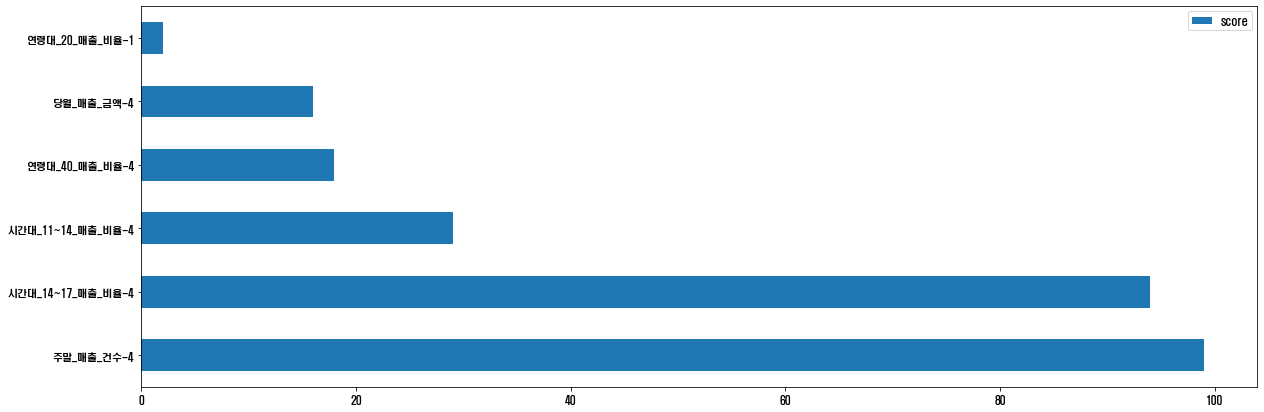

In [195]:
feature_important = xgb_CS300010.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
plt.rcParams["figure.figsize"] = (20,7)
data_50 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_50[:].plot(kind='barh')


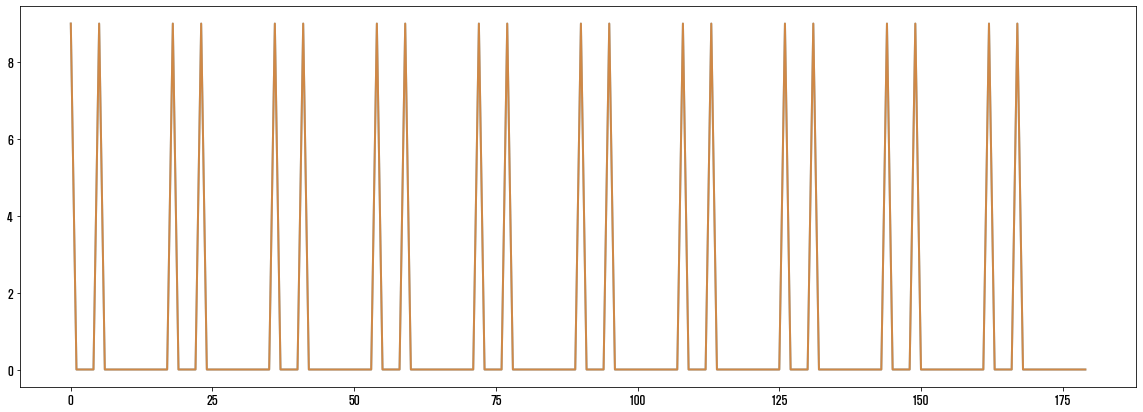

In [197]:
plt.pyplot.plot(xgb_CS300010.predict(x_in2.astype('float64')),alpha = 0.7,linewidth = 2)
# 파란색 : 예측값
# 주황색 : 실제값
# 갈색 : 파란색과 주황색이 겹치는 부분
plt.pyplot.plot(x_out2.values, alpha = 0.7,linewidth = 2)

### === 당해 성공 원인 분석

In [204]:
# 당해 데이터로 예측
current_in = all_data_in.drop(['기준_년_코드','기준_분기_코드','서비스_업종_코드'],axis=1)


current_out =  gangnam['폐업_률']

current_in = current_in.append(current_in)\
.append(current_in)\
.append(current_in)\
.append(current_in)


current_out =  current_out.append(current_out)\
.append(current_out)\
.append(current_out)\
.append(current_out)


current_in

,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,금요일_매출_비율,토요일_매출_비율,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
13,0.83,1.00,0.91,0.09,0.71,0.33,1.00,0.42,0.17,0.09,...,0.32,0.87,1.00,0.00,0.92,1.00,0.97,0.70,0.79,0.50
45,0.63,0.23,0.00,1.00,0.29,0.22,0.11,0.42,0.17,1.00,...,0.05,0.33,0.15,0.00,0.05,0.32,0.09,0.20,0.42,0.50
4,0.43,0.73,0.78,0.22,0.71,0.56,0.44,0.67,0.67,0.36,...,1.00,0.84,0.46,0.34,0.75,0.40,0.80,0.86,0.92,1.00
50,0.43,0.65,0.74,0.26,0.71,0.56,0.44,0.42,0.83,0.45,...,0.78,0.77,0.40,0.23,0.64,0.32,0.71,0.85,1.00,1.00
83,0.43,0.65,0.78,0.22,1.00,0.67,0.44,0.33,0.50,0.27,...,0.84,0.76,0.42,0.33,0.69,0.33,0.75,0.74,0.93,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.06,0.17,0.17,0.83,0.43,0.44,0.22,0.08,0.50,0.91,...,0.26,0.12,0.22,0.46,0.41,0.10,0.12,0.07,0.02,0.50
27,0.07,0.39,0.22,0.78,0.43,0.56,0.28,0.17,0.33,0.82,...,0.34,0.13,0.53,0.59,0.67,0.33,0.16,0.10,0.11,0.50
33,0.07,0.46,0.35,0.70,0.57,0.56,0.33,0.17,0.17,0.64,...,0.44,0.28,0.55,0.71,0.81,0.41,0.16,0.12,0.09,0.50
79,0.07,0.49,0.39,0.61,0.43,0.56,0.39,0.25,0.33,0.55,...,0.41,0.26,0.60,1.00,0.82,0.39,0.32,0.12,0.11,0.50


In [203]:
current_in.columns

Index(['당월_매출_금액', '당월_매출_건수', '주중_매출_비율', '주말_매출_비율', '월요일_매출_비율',
       '화요일_매출_비율', '수요일_매출_비율', '목요일_매출_비율', '금요일_매출_비율', '토요일_매출_비율',
       '일요일_매출_비율', '시간대_00~06_매출_비율', '시간대_06~11_매출_비율', '시간대_11~14_매출_비율',
       '시간대_14~17_매출_비율', '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '남성_매출_비율',
       '여성_매출_비율', '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율',
       '연령대_40_매출_비율', '연령대_50_매출_비율', '연령대_60_이상_매출_비율', '주중_매출_금액',
       '주말_매출_금액', '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액',
       '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액', '시간대_00~06_매출_금액',
       '시간대_06~11_매출_금액', '시간대_11~14_매출_금액', '시간대_14~17_매출_금액',
       '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액', '여성_매출_금액',
       '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액',
       '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수', '주말_매출_건수', '월요일_매출_건수',
       '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수', '금요일_매출_건수', '토요일_매출_건수',
       '일요일_매출_건수', '시간대_건수~06_매출_건수', '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수',
  

In [205]:
current_in_which_day = current_in[['월요일_매출_비율',\
       '화요일_매출_비율', '수요일_매출_비율', '목요일_매출_비율', '금요일_매출_비율', '토요일_매출_비율',\
       '일요일_매출_비율']]

current_in_when_time = current_in[['시간대_00~06_매출_비율', '시간대_06~11_매출_비율', '시간대_11~14_매출_비율',\
       '시간대_14~17_매출_비율', '시간대_17~21_매출_비율', '시간대_21~24_매출_비율']]

current_in_which_age = current_in[['연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율',
       '연령대_40_매출_비율', '연령대_50_매출_비율', '연령대_60_이상_매출_비율']]

current_in_sex = current_in[['남성_매출_비율','여성_매출_비율']]

In [209]:
import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
start = time.time()  # 시작 시간 저장
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test= train_test_split(current_in_which_day.astype('float64'), current_out.values, test_size=0.2, random_state=42)
# train, test 데이터 

# xgboost 학습
globals()["xgb_5000_{}".format('CS300017')] = XGBRegressor(booster="gbtree", objective ='reg:squarederror', n_estimators=1233, learning_rate=0.003 ,
                      max_depth=12, n_jobs = -1,subsample=0.8, reg_lambda=1, colsample_bytree=1, gamma=0, )

eval_set = [(X_test, y_test)]

globals()["xgb_5000_{}".format('CS300017')].fit(X_train,y_train, eval_set=eval_set, verbose=True)

globals()["xgb_5000_{}_pred".format('CS300017')] = globals()["xgb_5000_{}".format('CS300017')].predict(X_test)

#predictions = [round(value) for value in xgb_5000_강남구_pred ]
# evaluate predictions


[0]	validation_0-rmse:3.16586
[1]	validation_0-rmse:3.15905
[2]	validation_0-rmse:3.1519
[3]	validation_0-rmse:3.14476
[4]	validation_0-rmse:3.13815
[5]	validation_0-rmse:3.13105
[6]	validation_0-rmse:3.12575
[7]	validation_0-rmse:3.11852
[8]	validation_0-rmse:3.11197
[9]	validation_0-rmse:3.10492
[10]	validation_0-rmse:3.09774
[11]	validation_0-rmse:3.09058
[12]	validation_0-rmse:3.08358
[13]	validation_0-rmse:3.07645
[14]	validation_0-rmse:3.07024
[15]	validation_0-rmse:3.06379
[16]	validation_0-rmse:3.05861
[17]	validation_0-rmse:3.05153
[18]	validation_0-rmse:3.04512
[19]	validation_0-rmse:3.03858
[20]	validation_0-rmse:3.03245
[21]	validation_0-rmse:3.02608
[22]	validation_0-rmse:3.01972
[23]	validation_0-rmse:3.01274
[24]	validation_0-rmse:3.00627
[25]	validation_0-rmse:2.99995
[26]	validation_0-rmse:2.99316
[27]	validation_0-rmse:2.98624
[28]	validation_0-rmse:2.97934
[29]	validation_0-rmse:2.97392
[30]	validation_0-rmse:2.96704
[31]	validation_0-rmse:2.96018
[32]	validation_0-r

[261]	validation_0-rmse:1.80396
[262]	validation_0-rmse:1.7998
[263]	validation_0-rmse:1.79565
[264]	validation_0-rmse:1.79203
[265]	validation_0-rmse:1.7882
[266]	validation_0-rmse:1.78446
[267]	validation_0-rmse:1.78133
[268]	validation_0-rmse:1.7776
[269]	validation_0-rmse:1.7738
[270]	validation_0-rmse:1.77023
[271]	validation_0-rmse:1.76623
[272]	validation_0-rmse:1.76245
[273]	validation_0-rmse:1.75839
[274]	validation_0-rmse:1.75471
[275]	validation_0-rmse:1.75104
[276]	validation_0-rmse:1.747
[277]	validation_0-rmse:1.74297
[278]	validation_0-rmse:1.73992
[279]	validation_0-rmse:1.73612
[280]	validation_0-rmse:1.73263
[281]	validation_0-rmse:1.72892
[282]	validation_0-rmse:1.72494
[283]	validation_0-rmse:1.72104
[284]	validation_0-rmse:1.71744
[285]	validation_0-rmse:1.71435
[286]	validation_0-rmse:1.71126
[287]	validation_0-rmse:1.70768
[288]	validation_0-rmse:1.70383
[289]	validation_0-rmse:1.7004
[290]	validation_0-rmse:1.69656
[291]	validation_0-rmse:1.69264
[292]	validatio

[519]	validation_0-rmse:1.03947
[520]	validation_0-rmse:1.03767
[521]	validation_0-rmse:1.03555
[522]	validation_0-rmse:1.03322
[523]	validation_0-rmse:1.03102
[524]	validation_0-rmse:1.02865
[525]	validation_0-rmse:1.02628
[526]	validation_0-rmse:1.0245
[527]	validation_0-rmse:1.02232
[528]	validation_0-rmse:1.02015
[529]	validation_0-rmse:1.01792
[530]	validation_0-rmse:1.0158
[531]	validation_0-rmse:1.01376
[532]	validation_0-rmse:1.01161
[533]	validation_0-rmse:1.00945
[534]	validation_0-rmse:1.00743
[535]	validation_0-rmse:1.00511
[536]	validation_0-rmse:1.00301
[537]	validation_0-rmse:1.00075
[538]	validation_0-rmse:0.998742
[539]	validation_0-rmse:0.996663
[540]	validation_0-rmse:0.994414
[541]	validation_0-rmse:0.99217
[542]	validation_0-rmse:0.989932
[543]	validation_0-rmse:0.987698
[544]	validation_0-rmse:0.98547
[545]	validation_0-rmse:0.983247
[546]	validation_0-rmse:0.981272
[547]	validation_0-rmse:0.979131
[548]	validation_0-rmse:0.976878
[549]	validation_0-rmse:0.974631


[769]	validation_0-rmse:0.611741
[770]	validation_0-rmse:0.610446
[771]	validation_0-rmse:0.60907
[772]	validation_0-rmse:0.607806
[773]	validation_0-rmse:0.606478
[774]	validation_0-rmse:0.605111
[775]	validation_0-rmse:0.603831
[776]	validation_0-rmse:0.602553
[777]	validation_0-rmse:0.601194
[778]	validation_0-rmse:0.599881
[779]	validation_0-rmse:0.598528
[780]	validation_0-rmse:0.597221
[781]	validation_0-rmse:0.595982
[782]	validation_0-rmse:0.594959
[783]	validation_0-rmse:0.593618
[784]	validation_0-rmse:0.592362
[785]	validation_0-rmse:0.591026
[786]	validation_0-rmse:0.589988
[787]	validation_0-rmse:0.588658
[788]	validation_0-rmse:0.587413
[789]	validation_0-rmse:0.586064
[790]	validation_0-rmse:0.584719
[791]	validation_0-rmse:0.583506
[792]	validation_0-rmse:0.582505
[793]	validation_0-rmse:0.581232
[794]	validation_0-rmse:0.580212
[795]	validation_0-rmse:0.578904
[796]	validation_0-rmse:0.577742
[797]	validation_0-rmse:0.57652
[798]	validation_0-rmse:0.575342
[799]	valida

[1018]	validation_0-rmse:0.360476
[1019]	validation_0-rmse:0.359664
[1020]	validation_0-rmse:0.358906
[1021]	validation_0-rmse:0.358097
[1022]	validation_0-rmse:0.35736
[1023]	validation_0-rmse:0.356607
[1024]	validation_0-rmse:0.35587
[1025]	validation_0-rmse:0.355134
[1026]	validation_0-rmse:0.354334
[1027]	validation_0-rmse:0.353718
[1028]	validation_0-rmse:0.352973
[1029]	validation_0-rmse:0.352201
[1030]	validation_0-rmse:0.351394
[1031]	validation_0-rmse:0.350667
[1032]	validation_0-rmse:0.349877
[1033]	validation_0-rmse:0.349154
[1034]	validation_0-rmse:0.348367
[1035]	validation_0-rmse:0.347583
[1036]	validation_0-rmse:0.346851
[1037]	validation_0-rmse:0.346133
[1038]	validation_0-rmse:0.34534
[1039]	validation_0-rmse:0.344613
[1040]	validation_0-rmse:0.343887
[1041]	validation_0-rmse:0.343099
[1042]	validation_0-rmse:0.342539
[1043]	validation_0-rmse:0.341767
[1044]	validation_0-rmse:0.341047
[1045]	validation_0-rmse:0.340266
[1046]	validation_0-rmse:0.339675
[1047]	validation

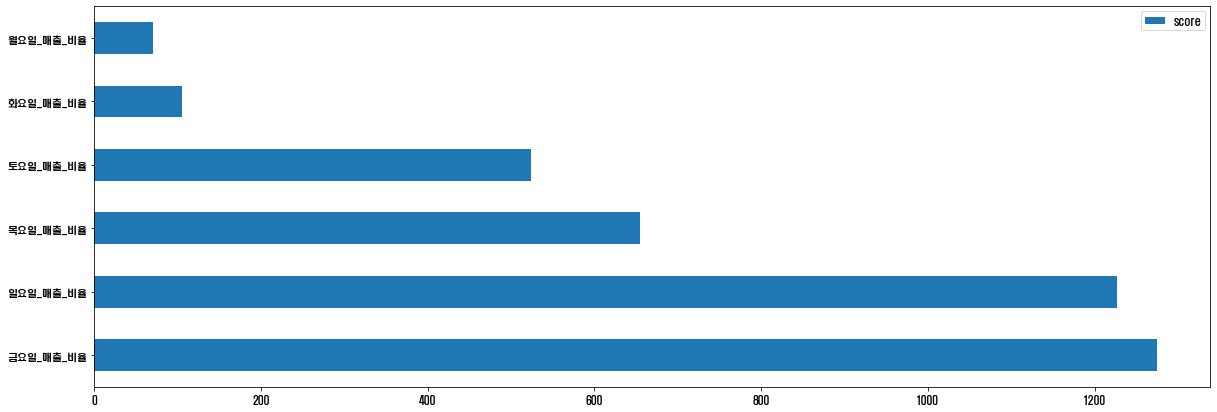

In [210]:
feature_important = xgb_5000_CS300017.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
plt.rcParams["figure.figsize"] = (20,7)
data_50 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_50[:13].plot(kind='barh')

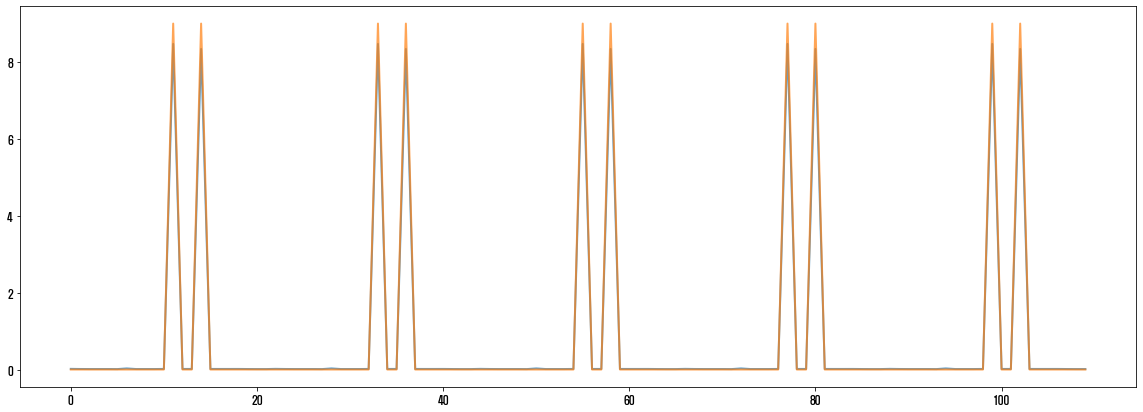

In [212]:
plt.pyplot.plot(xgb_5000_CS300017.predict(current_in_which_day.astype('float64')),alpha = 0.7,linewidth = 2)
# 파란색 : 예측값
# 주황색 : 실제값
# 갈색 : 파란색과 주황색이 겹치는 부분
plt.pyplot.plot(current_out.values, alpha = 0.7,linewidth = 2)